In [1]:
import torch
import pickle
import numpy as np
from pandas import factorize, DataFrame
from copy import deepcopy
from matplotlib import pyplot as plt

from uncertain.models.ExplicitFactorizationModel import ExplicitFactorizationModel
from uncertain.models.UncertainWrapper import UncertainWrapper, LinearUncertaintyEstimator
from uncertain.models.multimodelling import EnsembleRecommender, ResampleRecommender
from uncertain.cross_validation import random_train_test_split as split
from uncertain.interactions import Interactions
from uncertain.models.CPMF import CPMF
from uncertain.models.OrdRec import OrdRec

from utils import dataset_loader
from evaluation import evaluate

MF_params = {'embedding_dim': 10, 'n_iter': 100, 'l2': 9e-6, 'learning_rate': 0.05,
             'batch_size': int(1e6), 'use_cuda': True}
CPMF_params = {'embedding_dim': 10, 'n_iter': 100, 'sigma': 5e4, 'learning_rate': 0.05,
               'batch_size': int(1e6), 'use_cuda': True}
OrdRec_params = {'embedding_dim': 10, 'n_iter': 50, 'l2': 6e-8, 'learning_rate': 0.05,
                 'batch_size': int(1e6), 'use_cuda': True}


In [2]:
results = {'Baseline': [],
           'User support': [],
           'Item support': [],
           'Item variance': [],
           'Ensemble': [],
           'Resample': [],
           'FCV': [],
           'BCV': [],
           'CPMF': [],
           'OrdRec': []
           }

for seed in range(4):
    
    train, test = dataset_loader('goodbooks', seed)
    train.gpu()
    models = {}
    
    models['Baseline'] = ExplicitFactorizationModel(**MF_params)
    models['Baseline'].fit(train)
    
    models['User support'] = UncertainWrapper(models['Baseline'], LinearUncertaintyEstimator(-train.get_user_support(), None))
    models['Item support'] = UncertainWrapper(models['Baseline'], LinearUncertaintyEstimator(None, -train.get_item_support()))
    models['Item variance'] = UncertainWrapper(models['Baseline'], LinearUncertaintyEstimator(None, train.get_item_variance()))
    
    models['Ensemble'] = EnsembleRecommender(base_model=models['Baseline'], n_models=10)
    models['Ensemble'].fit(train)
    
    models['Resample'] = ResampleRecommender(base_model=models['Baseline'], n_models=10)
    models['Resample'].fit(train)
    
    fold1, fold2 = split(train, random_state=0, test_percentage=0.5)
    model_cv = deepcopy(models['Baseline'])
    model_cv._initialize(fold1)
    model_cv.fit(fold1)
    predictions1 = model_cv.predict(fold2.user_ids, fold2.item_ids)
    model_cv._initialize(fold2)
    model_cv.fit(fold2)
    predictions2 = model_cv.predict(fold1.user_ids, fold1.item_ids)
    train_errors = torch.cat((torch.abs(fold2.ratings - predictions1), torch.abs(fold1.ratings - predictions2)))
    train_errors = Interactions(torch.cat((fold2.user_ids, fold1.user_ids)),
                                torch.cat((fold2.item_ids, fold1.item_ids)),
                                train_errors, num_users=train.num_users, num_items=train.num_items)
    
    models['FCV'] = ExplicitFactorizationModel(**MF_params)
    models['FCV'].fit(train_errors)
    models['FCV'] = UncertainWrapper(models['Baseline'], models['FCV'])
    
    models['BCV'] = ExplicitFactorizationModel(**MF_params)
    models['BCV']._embedding_dim = 0
    models['BCV'].fit(train_errors)
    models['BCV'] = UncertainWrapper(models['Baseline'], models['BCV'])
    
    
    models['CPMF'] = CPMF(**CPMF_params)
    models['CPMF'].fit(train)
    
    factor = factorize(train.ratings.cpu(), sort=True)
    rating_labels = torch.from_numpy(factor[1].astype(np.float64)).cuda()
    train.ratings = torch.from_numpy(factor[0]).cuda()
    models['OrdRec'] = OrdRec(rating_labels, **OrdRec_params)
    models['OrdRec'].fit(train)
    
    test.gpu()
    results['Baseline'].append(evaluate(models['Baseline'], test, train, False))
    for key in list(results.keys())[1:]:
        results[key].append(evaluate(models[key], test, train, True))
        
with open('resultsGB.pkl', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

100%|██████████| 50/50 [00:38<00:00,  1.29it/s, Epoch 50 loss: -0.6370876928170522]


NameError: name 'pickle' is not defined

In [5]:
with open('resultsGB.pkl', 'rb') as f:
    results = pickle.load(f)

In [6]:
keys = ['Baseline', 'Ensemble', 'CPMF', 'OrdRec']
RMSE = [[results[key][i]['RMSE'].item() for i in range(4)] for key in keys]
RMSE = DataFrame(RMSE, index=keys, columns=['Fold '+str(i+1) for i in range(4)])
RMSE['Average'] = RMSE.mean(1)
RMSE['Std error'] = RMSE.std(1) / np.sqrt(4)
RMSE

,Fold 1,Fold 2,Fold 3,Fold 4,Average,Std error
Baseline,0.829731,0.830248,0.832243,0.829731,0.830488,0.000517
Ensemble,0.821459,0.822219,0.822816,0.822288,0.822196,0.000242
CPMF,0.867988,0.870232,0.869601,0.868453,0.869068,0.000446
OrdRec,0.979310,0.981124,0.980831,0.982662,0.980982,0.000595


In [7]:
precision = [[results[key][i]['Precision'].cpu().numpy() for i in range(4)] for key in keys]
precision = DataFrame(np.array(precision).mean(1), index=keys, columns=['Top '+str(i+1) for i in range(10)])
precision

,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10
Baseline,0.049628,0.043340,0.038979,0.035895,0.033640,0.031872,0.030461,0.029283,0.028313,0.027479
Ensemble,0.054398,0.047001,0.041984,0.038410,0.035718,0.033673,0.032095,0.030788,0.029643,0.028696
CPMF,0.055189,0.047610,0.042631,0.039038,0.036388,0.034240,0.032517,0.031144,0.029978,0.029008
OrdRec,0.010862,0.010511,0.010364,0.010325,0.010256,0.010223,0.010176,0.010074,0.010023,0.009946


In [8]:
recall = [[results[key][i]['Recall'].cpu().numpy() for i in range(4)] for key in keys]
recall = DataFrame(np.array(recall).mean(1), index=keys, columns=['Top '+str(i+1) for i in range(10)])
recall

,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10
Baseline,0.004527,0.007835,0.010560,0.012932,0.015126,0.017169,0.019118,0.020997,0.022828,0.024609
Ensemble,0.004995,0.008559,0.011420,0.013896,0.016150,0.018249,0.020275,0.022193,0.024015,0.025834
CPMF,0.005123,0.008749,0.011657,0.014181,0.016486,0.018585,0.020573,0.022490,0.024325,0.026132
OrdRec,0.000971,0.001878,0.002782,0.003693,0.004578,0.005475,0.006357,0.007184,0.008034,0.008865


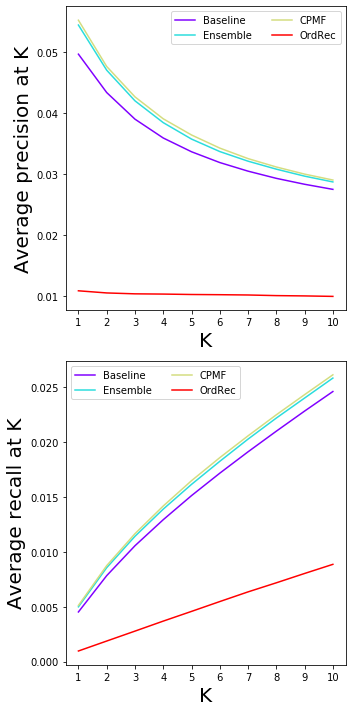

In [9]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 4)))
f, ax = plt.subplots(nrows=2, figsize=(5, 10))
for key in keys:
    c = next(color)
    ax[0].plot(np.arange(1, 11), precision.loc[key], '-', color=c, label=key)
    ax[1].plot(np.arange(1, 11), recall.loc[key], '-', color=c, label=key)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('K', Fontsize=20)
ax[0].set_ylabel('Average precision at K', Fontsize=20)
ax[0].legend(ncol=2)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xticklabels(np.arange(1, 11))
ax[1].set_xlabel('K', Fontsize=20)
ax[1].set_ylabel('Average recall at K', Fontsize=20)
ax[1].legend(ncol=2)
f.tight_layout()

In [10]:
keys = list(results.keys())[1:]
RPI = np.array([[results[key][i]['RPI'].item() for i in range(4)] for key in keys])
Pearson = np.array([[results[key][i]['Correlation'][0].item() for i in range(4)] for key in keys])
Spearman = np.array([[results[key][i]['Correlation'][1].item() for i in range(4)] for key in keys])
out = DataFrame([RPI.mean(1),
                 RPI.std(1) / np.sqrt(4),
                 Pearson.mean(1),
                 Pearson.std(1) / np.sqrt(4),
                 Spearman.mean(1),
                 Spearman.std(1) / np.sqrt(4)],
                index=['Average RPI', 'RPI SE', 'Average Pearson correlation', 'Pearson correlation SE', 
                       'Average Spearman correlation', 'Spearman correlation SE'], columns=keys)
out.T

,Average RPI,RPI SE,Average Pearson correlation,Pearson correlation SE,Average Spearman correlation,Spearman correlation SE
User support,0.045146,0.002945,0.017996,0.000852,0.016333,0.000826
Item support,-0.020777,0.004300,0.030649,0.000548,0.060569,0.000524
Item variance,0.477292,0.001919,0.123537,0.000102,0.110352,0.000208
Ensemble,0.421308,0.006850,0.086701,0.000900,0.032338,0.000287
Resample,0.564661,0.008615,0.117260,0.001056,0.066769,0.000295
FCV,0.949514,0.003618,0.281904,0.000812,0.272668,0.000694
BCV,0.970200,0.002542,0.299124,0.000614,0.268353,0.000504
CPMF,0.922590,0.002265,0.308148,0.000689,0.289104,0.000535
OrdRec,0.429643,0.005541,0.165454,0.000550,0.347285,0.000620


In [11]:
rmse = [[results[key][i]['Quantile RMSE'].cpu().numpy() for i in range(4)] for key in keys]
rmse = DataFrame(np.array(rmse).mean(1), index=keys, columns=['Bin '+str(i+1) for i in range(20)])
rmse

,Bin 1,Bin 2,Bin 3,Bin 4,Bin 5,Bin 6,Bin 7,Bin 8,Bin 9,Bin 10,Bin 11,Bin 12,Bin 13,Bin 14,Bin 15,Bin 16,Bin 17,Bin 18,Bin 19,Bin 20
User support,0.827590,0.820703,0.817996,0.827259,0.822662,0.823458,0.830050,0.824140,0.828324,0.829373,0.826229,0.831394,0.830047,0.828567,0.830642,0.830703,0.828866,0.836109,0.835974,0.874211
Item support,0.771971,0.857990,0.866564,0.843665,0.850986,0.836375,0.828195,0.829179,0.802813,0.814179,0.797900,0.802217,0.798364,0.802587,0.807213,0.810068,0.817223,0.829127,0.868263,0.953961
Item variance,0.662211,0.716850,0.735872,0.758162,0.759877,0.779950,0.782112,0.800557,0.798278,0.814985,0.820048,0.838010,0.849963,0.859221,0.868232,0.893150,0.907385,0.928872,0.942094,1.009956
Ensemble,0.755840,0.786214,0.793497,0.802431,0.804868,0.807408,0.805468,0.803461,0.804628,0.792484,0.793458,0.787608,0.791565,0.794923,0.803650,0.819309,0.835744,0.864890,0.916442,1.037051
Resample,0.686656,0.737817,0.766952,0.787438,0.801816,0.810791,0.816973,0.817455,0.819811,0.814233,0.805941,0.802803,0.804638,0.809537,0.821366,0.834742,0.858193,0.892928,0.946817,1.095532
FCV,0.485017,0.565536,0.619974,0.653599,0.682390,0.711134,0.729579,0.755043,0.775214,0.796119,0.815164,0.838318,0.856741,0.883735,0.909622,0.940583,0.970678,1.017934,1.072628,1.181344
BCV,0.450779,0.569798,0.620953,0.654559,0.682629,0.709213,0.733056,0.753400,0.774785,0.795399,0.812441,0.834870,0.855453,0.879616,0.902952,0.934369,0.966918,1.009730,1.070999,1.221775
CPMF,0.598109,0.624963,0.650553,0.678188,0.696792,0.725122,0.744790,0.768249,0.791045,0.810254,0.833393,0.858305,0.878299,0.910750,0.935962,0.971143,1.014326,1.065822,1.142049,1.309561
OrdRec,0.957830,0.970617,0.953499,0.921811,0.904573,0.899182,0.912782,0.920655,0.934241,0.945426,0.957725,0.973911,0.983496,0.999034,1.000904,1.007914,0.997654,0.981791,1.018280,1.307097


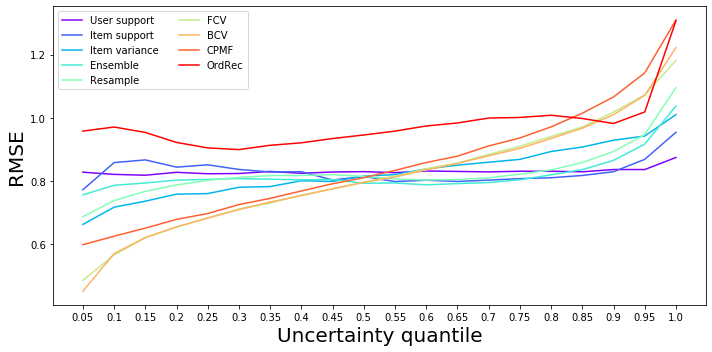

In [12]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    c = next(color)
    ax.plot(np.arange(1, 21), rmse.loc[key], '-', color=c, label=key)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels(np.round(np.linspace(start=0.05, stop=1, num=20, endpoint=True), 2))
ax.set_xlabel('Uncertainty quantile', Fontsize=20)
ax.set_ylabel('RMSE', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()

In [13]:
MAP = [[results[key][i]['Quantile MAP'].cpu().numpy() for i in range(4)] for key in keys if 'Item' not in key]
MAP = DataFrame(np.array(MAP).mean(1), index=[k for k in keys if 'Item' not in k], columns=['Bin '+str(i+1) for i in range(20)])
MAP

,Bin 1,Bin 2,Bin 3,Bin 4,Bin 5,Bin 6,Bin 7,Bin 8,Bin 9,Bin 10,Bin 11,Bin 12,Bin 13,Bin 14,Bin 15,Bin 16,Bin 17,Bin 18,Bin 19,Bin 20
User support,0.037213,0.036133,0.032775,0.033378,0.032608,0.030640,0.030787,0.028183,0.027826,0.027969,0.027375,0.026763,0.026091,0.024940,0.024586,0.024328,0.023573,0.021510,0.019044,0.015770
Ensemble,0.011113,0.015590,0.019122,0.021332,0.021517,0.024223,0.025915,0.026142,0.027172,0.029610,0.028848,0.030893,0.031841,0.033567,0.032575,0.034245,0.037303,0.037447,0.040927,0.044563
Resample,0.013847,0.019270,0.020105,0.023223,0.023982,0.024848,0.025241,0.026170,0.026882,0.027989,0.029167,0.029450,0.029644,0.030399,0.032182,0.033177,0.033140,0.032444,0.034129,0.034298
FCV,0.019464,0.024150,0.024401,0.027137,0.027004,0.027135,0.027901,0.027659,0.028483,0.028046,0.028446,0.027915,0.029663,0.028404,0.029719,0.028626,0.029111,0.030321,0.028418,0.027583
BCV,0.020672,0.024747,0.024525,0.026622,0.027931,0.026620,0.027892,0.028155,0.028540,0.028261,0.027856,0.029216,0.028574,0.028697,0.028802,0.028720,0.029448,0.028757,0.028371,0.027180
CPMF,0.015963,0.021985,0.023832,0.025311,0.025814,0.026086,0.028294,0.028970,0.029607,0.028963,0.030777,0.031108,0.029885,0.031357,0.031507,0.033243,0.032575,0.033730,0.035993,0.035178
OrdRec,0.008576,0.009176,0.009448,0.009832,0.009176,0.010140,0.009600,0.008830,0.009550,0.009093,0.009953,0.010413,0.010158,0.009366,0.010178,0.009795,0.010721,0.010272,0.011227,0.013403


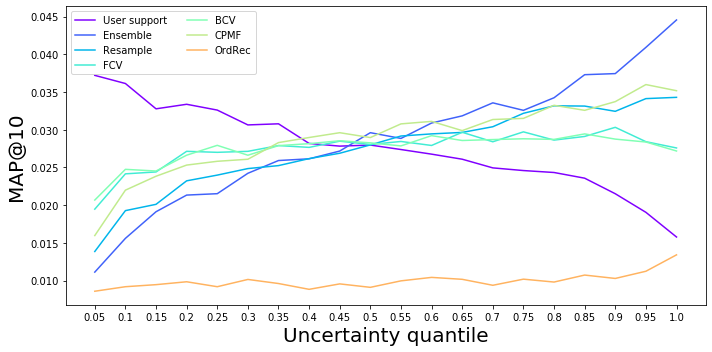

In [14]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in [key for key in keys if 'Item' not in key]:
    c = next(color)
    ax.plot(np.arange(1, 21), MAP.loc[key], '-', color=c, label=key)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels(np.round(np.linspace(start=0.05, stop=1, num=20, endpoint=True), 2))
ax.set_xlabel('Uncertainty quantile', Fontsize=20)
ax.set_ylabel('MAP@10', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()

In [15]:
RRI = [[results[key][i]['RRI'].cpu().numpy() for i in range(4)] for key in keys if 'User' not in key]
RRI = DataFrame(np.array(RRI).mean(1), index=[key for key in keys if 'User' not in key], columns=['Top '+str(i+2) for i in range(9)])
RRI

,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,Top 10
Item support,0.325032,0.513243,0.636778,0.719198,0.777824,0.824018,0.858602,0.878616,0.900369
Item variance,-0.128984,-0.186915,-0.235599,-0.272218,-0.300520,-0.320929,-0.339664,-0.354496,-0.364928
Ensemble,-0.157950,-0.186823,-0.196840,-0.203016,-0.211496,-0.214970,-0.214153,-0.211455,-0.212206
Resample,-0.054599,-0.043375,-0.046181,-0.049907,-0.052372,-0.056000,-0.063359,-0.065294,-0.069451
FCV,0.021730,0.029065,0.020675,0.011161,-0.002364,-0.012906,-0.021646,-0.029483,-0.035997
BCV,-0.060360,-0.085288,-0.115247,-0.143343,-0.167854,-0.187192,-0.205337,-0.221159,-0.231144
CPMF,0.077614,0.098679,0.113771,0.121464,0.127747,0.128439,0.129735,0.128418,0.124803
OrdRec,0.005614,0.001007,0.015277,0.022235,0.025695,0.026522,0.032138,0.038887,0.042334


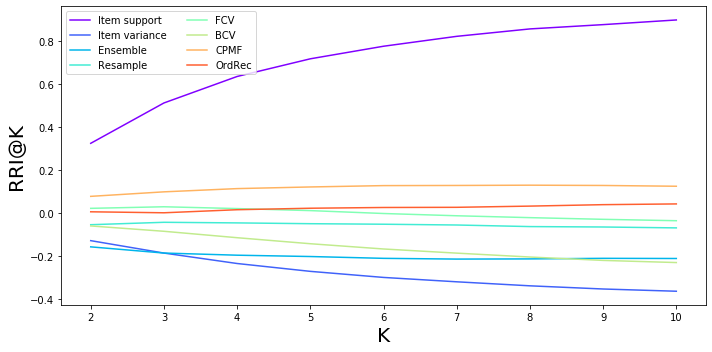

In [16]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in [key for key in keys if 'User' not in key]:
    c = next(color)
    ax.plot(np.arange(2, 11), RRI.loc[key], '-', color=c, label=key)
ax.set_xlabel('K', Fontsize=20)
ax.set_ylabel('RRI@K', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()

In [17]:
Likelihood = np.array([[results[key][i]['Classification'][0].item() for i in range(4)] for key in keys])
AUC = np.array([[results[key][i]['Correlation'][1].item() for i in range(4)] for key in keys])
out = DataFrame([Likelihood.mean(1), AUC.mean(1)], index=['log-Likelihood', 'AUC'], columns=keys)
out.T

,log-Likelihood,AUC
User support,-0.521912,0.016333
Item support,-0.521686,0.060569
Item variance,-0.516819,0.110352
Ensemble,-0.514688,0.032338
Resample,-0.518223,0.066769
FCV,-0.495821,0.272668
BCV,-0.490661,0.268353
CPMF,-0.516621,0.289104
OrdRec,-0.528234,0.347285
